### Imports

In [1]:
import os, sys, ast, json, math
import pandas as pd
import numpy as np
from geopy import distance
from datetime import datetime, timedelta
from scipy.stats import linregress
from scipy import stats
from random import random
import itertools

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/complexsystems/'

Mounted at /content/drive


### Functions

In [3]:
def read_file(filename):
  tmp = pd.read_csv(filename, converters={"coords1": ast.literal_eval, "coords2": ast.literal_eval})
  for c in ['time1', 'time2']:
    tmp[c] = pd.to_datetime(tmp[c])
  return tmp

In [4]:
# normal distribuzion, z score...
def remove_outliers(df, column):
  return df[(np.abs(stats.zscore(df[column])) < 3)].copy()

In [5]:
# into intervals of size n
def regroup_values(values, n):
  return [n*(h//n) for h in values]

In [6]:
# given a df with date intervals (only two datetime columns), returns the sequence of events, with count of overlapping intervals
def get_overlapping_intervals(df_intervals):
  new_df = df_intervals.melt(var_name='status', value_name='time').sort_values('time')
  new_df['counter'] = np.where(new_df['status'].eq(df_intervals.columns[0]),1,-1).cumsum()
  return new_df.reset_index(drop=True)

### Read files

In [17]:
city = 'san_jose'

In [18]:
df = pd.read_csv(base_path+'data/preprocessed/preprocessed_data_'+city+'.csv', converters={"coords1": ast.literal_eval, "coords2": ast.literal_eval})
for c in ['time1', 'time2']:
  df[c] = pd.to_datetime(df[c])
len(df)

902779

In [19]:
# df = remove_outliers(df, 'duration')
df['hour'] = regroup_values(list(df['time1'].dt.hour), 3)
df['weekend'] = df['time1'].dt.dayofweek > 4
df['season'] = df['time1'].dt.month % 12 // 3 + 1 # le raggruppa a inizio mese, non nella data precisa
df['date'] = df['time1'].dt.date

ids = list(set(df['id1']).union(df['id2']))
stats_path = base_path+'data/stats/' + city + '/'

### Exploration

In [20]:
print('Number of trips:', len(df))
print('Number of stations:', len(set(df['id1']).union(set(df['id2']))))

Number of trips: 902779
Number of stations: 130


<BarContainer object of 85 artists>

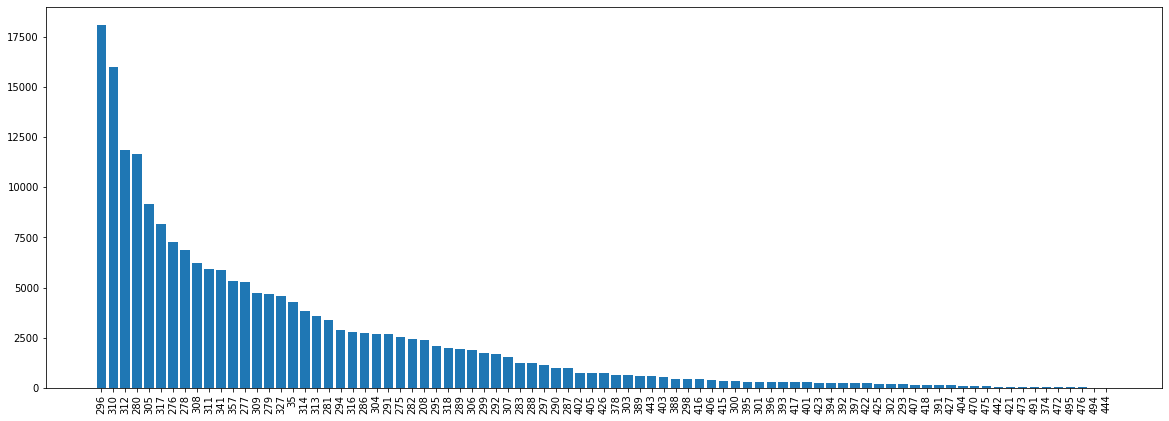

In [ ]:
x = pd.value_counts(df['id1'])
labels = [str(l) for l in x.index]
count = list(x)

plt.rcParams["figure.figsize"] = (20,7)
plt.xticks(rotation=90)
plt.bar(labels, count)

<BarContainer object of 85 artists>

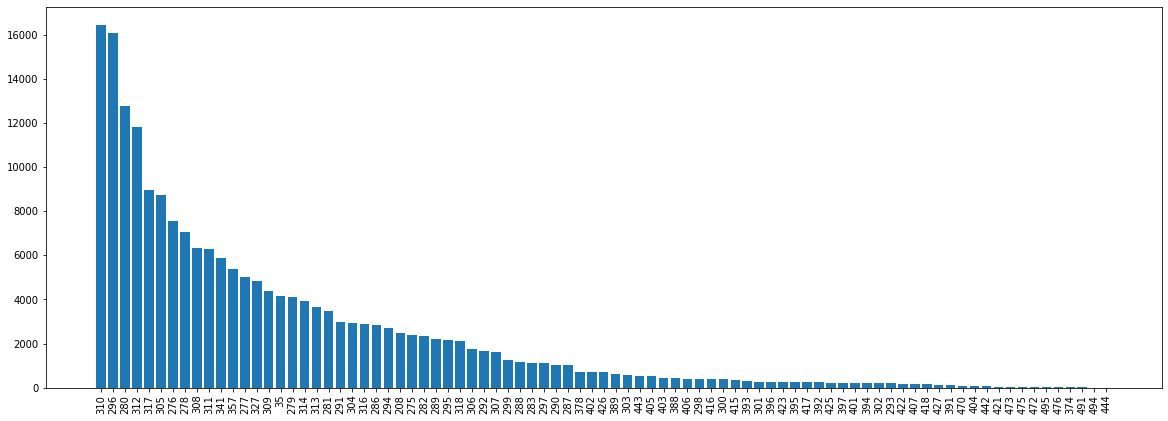

In [ ]:
x = pd.value_counts(df['id2'])
labels = [str(l) for l in x.index]
count = list(x)

plt.rcParams["figure.figsize"] = (20,7)
plt.xticks(rotation=90)
plt.bar(labels, count)

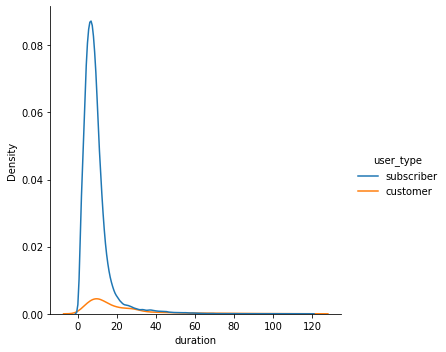

In [ ]:
tmp = df[df['duration']<120].copy()
sns.displot(data=tmp, x="duration", hue="user_type", kind="kde")

In [ ]:
df

,time1,time2,id1,id2,name1,name2,coords1,coords2,duration,bike_id,user_type,hour,weekend,season,date
0,2018-01-31 23:34:14.027,2018-01-31 23:47:59.809,305,317,Ryland Park,San Salvador St at 9th St,"(37.342725, -121.895617)","(37.333955, -121.877349)",13.750000,1453,subscriber,21,False,1,2018-01-31
1,2018-01-31 23:24:16.357,2018-01-31 23:39:04.123,308,297,San Pedro Square,Locust St at Grant St,"(37.336802, -121.8940901)","(37.3229796, -121.8879312)",14.783333,55,subscriber,21,False,1,2018-01-31
2,2018-01-31 23:07:15.313,2018-01-31 23:18:41.558,312,317,San Jose Diridon Station,San Salvador St at 9th St,"(37.329732, -121.901782)","(37.333955, -121.877349)",11.433333,1886,subscriber,21,False,1,2018-01-31
3,2018-01-31 21:55:12.779,2018-01-31 22:00:41.111,314,278,Santa Clara St at Almaden Blvd,The Alameda at Bush St,"(37.333988, -121.894902)","(37.3319323, -121.9048882)",5.466667,3601,subscriber,21,False,1,2018-01-31
4,2018-01-31 21:46:44.107,2018-01-31 21:50:09.909,279,275,Santa Clara St at 7th St,Julian St at 6th St,"(37.3391456, -121.8841054)","(37.3429973, -121.8888891)",3.416667,1709,subscriber,21,False,1,2018-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198328,2019-12-11 17:03:48.000,2019-12-11 17:29:12.000,396,393,Metro Dr at Technology Dr,Asbury St at The Alameda,"(37.3676780524, -121.9187942147)","(37.3380223131, -121.919478178)",25.400000,444458,customer,15,False,1,2019-12-11
198329,2019-12-10 08:42:26.000,2019-12-10 08:43:55.000,396,396,Metro Dr at Technology Dr,Metro Dr at Technology Dr,"(37.3676780524, -121.9187942147)","(37.3676780524, -121.9187942147)",1.483333,444458,customer,6,False,1,2019-12-10
198330,2019-12-11 15:22:07.000,2019-12-11 15:39:10.000,396,313,Metro Dr at Technology Dr,Almaden Blvd at San Fernando St,"(37.3676780524, -121.9187942147)","(37.331415, -121.8932)",17.050000,546220,subscriber,15,False,1,2019-12-11
198331,2019-12-09 15:55:01.000,2019-12-09 16:12:20.000,396,313,Metro Dr at Technology Dr,Almaden Blvd at San Fernando St,"(37.3676780524, -121.9187942147)","(37.331415, -121.8932)",17.316667,367166,subscriber,15,False,1,2019-12-09


In [ ]:
import folium
from folium.plugins import HeatMap
tmp = df.copy()
#tmp = tmp.drop_duplicates('id1', keep='first')
tmp['lat1'] = tmp['coords1'].apply(lambda x: x[0])
tmp['lng1'] = tmp['coords1'].apply(lambda x: x[1])


# find the row of the house which has the highest price
maxpr=tmp.loc[df['duration'].idxmax()]
minpr=tmp.loc[df['duration'].idxmin()]

# define a function to draw a basemap easily
def generateBaseMap(default_location=[37.5112, -121.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_copy = tmp.copy()
# select a zipcode for the heatmap
#set(df['zipcode'])
#df_copy = df[df['zipcode']==98002].copy()
#df_copy = df[df['zipcode']==98019].copy()
#df_copy=df2_split[2].copy()

df_copy['duration'] = 1

basemap = generateBaseMap()
# add carton position map
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
# add a marker for the house which has the highest price
folium.Marker([maxpr['lat1'], maxpr['lng1']],popup='Highest Price: $'+str(format(maxpr['duration'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
folium.Marker([minpr['lat1'], minpr['lng1']],popup='Lowest Price: $'+str(format(minpr['duration'],'.0f')),
              icon=folium.Icon(color='red')).add_to(s)
# add heatmap
HeatMap(data=df_copy[['lat1','lng1','duration']].groupby(['lat1','lng1']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)

basemap.add_child(folium.LatLngPopup())

#folium.Rectangle([(47.1559,-122.519), (47.2000,-122.500)]).add_to(basemap)


#folium.CircleMarker(
#    location=[47.2977, -122.2713],
 #   radius=30,
  #  popup="98001",
   # color="#3186cc",
    #fill=True,
    #fill_color="#3186cc",
#).add_to(basemap)

basemap

In [ ]:
tmp = df.copy()
tmp = tmp.drop_duplicates('id1', keep='first')
tmp['lat1'] = tmp['coords1'].apply(lambda x: x[0])
tmp['lng1'] = tmp['coords1'].apply(lambda x: x[1])

import plotly.express as px

fig = px.scatter_mapbox(tmp, lat="lat1", lon="lng1", hover_name="name1", hover_data=["id1"],
                        color_discrete_sequence=["fuchsia"], zoom=8, height=700, width=800)
fig.update_traces(marker={'size': 10})
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
tmp

,time1,time2,id1,id2,name1,name2,coords1,coords2,duration,bike_id,user_type,hour,weekend,season,date,lat1,lng1
0,2018-01-31 23:34:14.027,2018-01-31 23:47:59.809,305,317,Ryland Park,San Salvador St at 9th St,"(37.342725, -121.895617)","(37.333955, -121.877349)",13.750000,1453,subscriber,21,False,1,2018-01-31,(,3
1,2018-01-31 23:24:16.357,2018-01-31 23:39:04.123,308,297,San Pedro Square,Locust St at Grant St,"(37.336802, -121.8940901)","(37.3229796, -121.8879312)",14.783333,55,subscriber,21,False,1,2018-01-31,(,3
2,2018-01-31 23:07:15.313,2018-01-31 23:18:41.558,312,317,San Jose Diridon Station,San Salvador St at 9th St,"(37.329732, -121.901782)","(37.333955, -121.877349)",11.433333,1886,subscriber,21,False,1,2018-01-31,(,3
3,2018-01-31 21:55:12.779,2018-01-31 22:00:41.111,314,278,Santa Clara St at Almaden Blvd,The Alameda at Bush St,"(37.333988, -121.894902)","(37.3319323, -121.9048882)",5.466667,3601,subscriber,21,False,1,2018-01-31,(,3
4,2018-01-31 21:46:44.107,2018-01-31 21:50:09.909,279,275,Santa Clara St at 7th St,Julian St at 6th St,"(37.3391456, -121.8841054)","(37.3429973, -121.8888891)",3.416667,1709,subscriber,21,False,1,2018-01-31,(,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173258,2019-10-28 13:17:44.001,2019-10-28 13:27:03.191,476,208,19th St at William St,4th St at San Carlos St,"(37.3384680141, -121.8665206432)","(37.3327995239, -121.8838503957)",9.316667,7174,customer,12,False,4,2019-10-28,(,3
183802,2019-11-27 15:48:31.579,2019-11-27 16:01:12.717,491,277,Devine St at San Pedro St,W Julian St at N Morrison St,"(37.3386706046, -121.8956440687)","(37.3336771229, -121.9086179137)",12.683333,12706,subscriber,15,False,4,2019-11-27,(,3
193413,2019-12-31 12:41:45.433,2019-12-31 13:02:37.082,495,423,St James St at 9th St,South San Jose State (7th St at Humboldt St),"(37.3432084885, -121.8843895197)","(37.3203158211, -121.8700987101)",20.850000,3358,customer,12,False,1,2019-12-31,(,3
193913,2019-12-21 11:54:51.454,2019-12-21 12:05:11.019,444,444,Mercado Way at Sierra Rd,Mercado Way at Sierra Rd,"(37.3711164134, -121.8813318014)","(37.3711164134, -121.8813318014)",10.316667,9215,customer,9,True,1,2019-12-21,(,3


### Decide how to group hours / days of week / months

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)

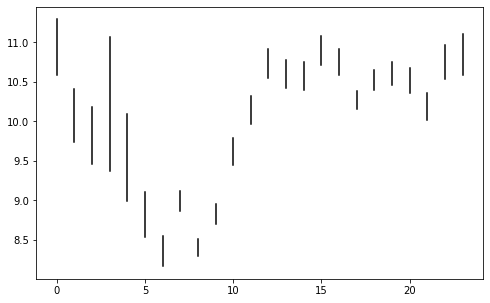

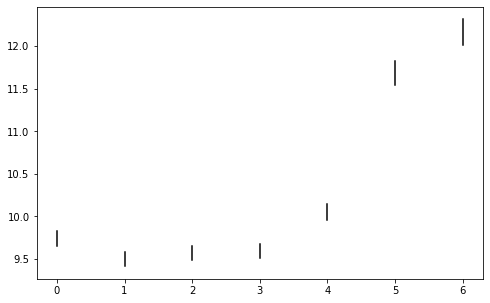

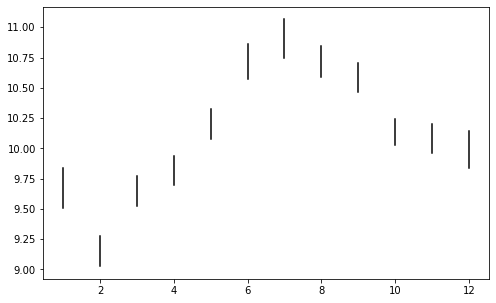

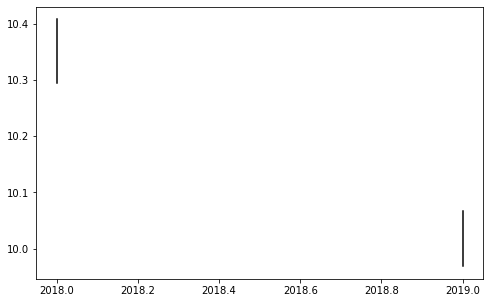

In [ ]:
tmp = df.copy()
tmp['year'] = tmp['time1'].dt.year
tmp['month'] = tmp['time1'].dt.month
tmp['dayofweek'] = tmp['time1'].dt.dayofweek
tmp['hour'] = tmp['time1'].dt.hour

for col in ['hour', 'dayofweek', 'month', 'year']:

  x = tmp[[col, 'duration']].copy()
  x = x.groupby([col])['duration'].agg(['mean', 'count', 'std'])

  ci95_hi = []
  ci95_lo = []

  for i in x.index:
      m, c, s = x.loc[i]
      ci95_hi.append(m + 1.96*s/math.sqrt(c))
      ci95_lo.append(m - 1.96*s/math.sqrt(c))

  x['ci95_lo'] = ci95_lo
  x['ci95_hi'] = ci95_hi
  x = x.reset_index().dropna()

  for i in range(len(x)):
    row = x.iloc[i]
    xx = (row[col], row[col])
    yy = (row['ci95_lo'], row['ci95_hi'])
    plt.plot(xx, yy, color='black'),
  plt.show();

# commenti sui risultati
# - ora -> divisione a gruppi di 3
# - dayofweek -> divisione per weekend (binario)
# - mese -> divisione per stagione
# - anno cambia poco -> ignorare

### OLD Statistiche su viaggi e tempistiche


Calcolo media e dev std di numero e durata viaggi, per ogni:  
- two stations
- hour range
- weekend
- season

In [ ]:
cols = ['season', 'weekend', 'hour', 'id1', 'id2']
base_df1 = df[cols+['date', 'bike_id']].copy()
base_df1 = base_df1.groupby(cols+['date']).count().reset_index()
base_df2 = df[cols+['duration']].copy()

# count
tmp1 = base_df1.copy().groupby(cols).mean().reset_index()
tmp2 = base_df1.copy().groupby(cols).std().reset_index()

# duration
tmp3 = base_df2.copy().groupby(cols).mean().reset_index()
tmp4 = base_df2.copy().groupby(cols).std().reset_index()

# move into first df
tmp1.rename(columns={'bike_id': 'avg_count'}, inplace=True)
tmp1['std_count'] = tmp2['bike_id']
tmp1['avg_duration'] = tmp3['duration']
tmp1['std_duration'] = tmp4['duration']

# set null and zero standard deviations to random number in [0,1)
for c in ['std_count', 'std_duration']:
  tmp1[c] = tmp1[c].fillna(0)
  tmp1[c] = tmp1[c].apply(lambda x: random() if x == 0 else x) 

# sort 
tmp1 = tmp1.sort_values(by='avg_count', ascending=False)
tmp1

,season,weekend,hour,id1,id2,avg_count,std_count,avg_duration,std_duration
82110,3,False,3,243,253,12.0,0.516310,1.354167,0.134300
82148,3,False,3,253,243,12.0,0.803928,2.129167,0.323345
121735,3,True,15,265,176,10.0,0.852548,33.346667,3.098843
123002,3,True,18,176,187,10.0,0.318454,24.220000,0.606131
125722,3,True,21,171,186,9.0,0.743654,52.262963,11.061563
...,...,...,...,...,...,...,...,...,...
62460,2,False,21,180,172,1.0,0.910806,18.916667,0.449653
62461,2,False,21,180,174,1.0,0.543323,14.733333,0.596586
62462,2,False,21,180,175,1.0,0.632415,10.905556,1.080166
62463,2,False,21,180,176,1.0,0.540129,8.916667,4.195500


In [ ]:
tmp1.to_csv(stats_path + 'trips_stats.csv', index=False)

### OLD Statistiche sulle bici in circolazione

In [ ]:
def get_max_parked_bikes(df, station):

  # create df with list of intervals in which each bike is parked (ignoring bike movements by the company for mantainance)
  tmp = df[['time1', 'time2', 'id1', 'id2', 'bike_id']].copy()
  tmp = tmp[(tmp['id1']==station) | (tmp['id2']==station)].sort_values(by='time1')

  rows = []
  for b in set(tmp['bike_id']):
    tmp_b = tmp[tmp['bike_id']==b]
    
    for i in range(1,len(tmp_b)):
      r1 = tmp_b.iloc[i-1]
      r2 = tmp_b.iloc[i]
      if (r1['id2'] == station) and (r2['id1'] == station):
        rows.append([r1['time2'], r2['time1']])

  t = pd.DataFrame(rows, columns=['start', 'end']).sort_values(by='start')

  # calculate max number of bikes parked at the same time
  df_count = get_overlapping_intervals(t)
  return np.mean(df_count['counter'])


x = [(i, get_max_parked_bikes(df, i)) for i in ids]
x = pd.DataFrame(x, columns=['id', 'max_parked_bikes']).sort_values(by='max_parked_bikes', ascending=False)
x = x.fillna(0)
# x.to_csv(stats_path + 'max_parked_bikes_by_station.csv', index=False)
x

,id,max_parked_bikes
36,312,13.886916
34,310,13.079663
5,280,13.076321
20,296,12.437561
17,293,10.121795
...,...,...
82,491,1.642857
45,374,1.500000
67,421,1.203704
75,444,0.500000


In [ ]:
plt.rcParams["figure.figsize"] = (14,8)

In [ ]:
# running bikes distribution
t = df[['time1', 'time2']].copy()
df_count = get_overlapping_intervals(t)

x = df_count[['time', 'counter']].copy()
x.set_index('time', inplace=True)
x = x.resample('d').max()
plt.plot(x)
plt.savefig(stats_path + 'daily_max_running_bikes.png', bbox_inches='tight')
plt.show();

x = df_count[['time', 'counter']].copy()
x.set_index('time', inplace=True)
x = x.resample('m').max()
plt.plot(x)
plt.savefig(stats_path + 'monthly_max_running_bikes.png', bbox_inches='tight')
plt.show();

In [ ]:
tmp = df.copy()
tmp['date'] = tmp['time1'].dt.date
tmp['year'] = tmp['time1'].dt.year
tmp['month'] = tmp['time1'].dt.month

# unique daily bikes list
tmp1 = tmp[['date', 'bike_id']].copy()
tmp1 = tmp1.groupby(['date']).nunique().reset_index()
tmp1.set_index('date', inplace=True)
plt.plot(tmp1[['bike_id']])
plt.savefig(stats_path + 'daily_unique_bikes.png', bbox_inches='tight')
plt.show();

# unique monthly bikes list
tmp = tmp[['year', 'month', 'bike_id']]
tmp = tmp.groupby(['year', 'month']).nunique().reset_index()
tmp.index = tmp.apply(lambda x: datetime(x['year'], x['month'], 1), axis=1)
plt.plot(tmp[['bike_id']])
plt.savefig(stats_path + 'monthly_unique_bikes.png', bbox_inches='tight')
plt.show();

### Boh

In [ ]:
pd.value_counts(df['id1']).head(5)

296    18094
310    16025
312    11880
280    11668
305     9183
Name: id1, dtype: int64

In [ ]:
pd.value_counts(df['id2']).head(5)

310    16440
296    16081
280    12776
312    11830
317     8953
Name: id2, dtype: int64

In [ ]:
tmp = df[df['id1']==296].copy()
tmp = tmp[['time1']]
tmp['count'] = [1]*len(tmp)
tmp.set_index('time1', inplace=True)
tmp = tmp['2018-05-01':'2018-05-31']
tmp = tmp.resample('d').sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



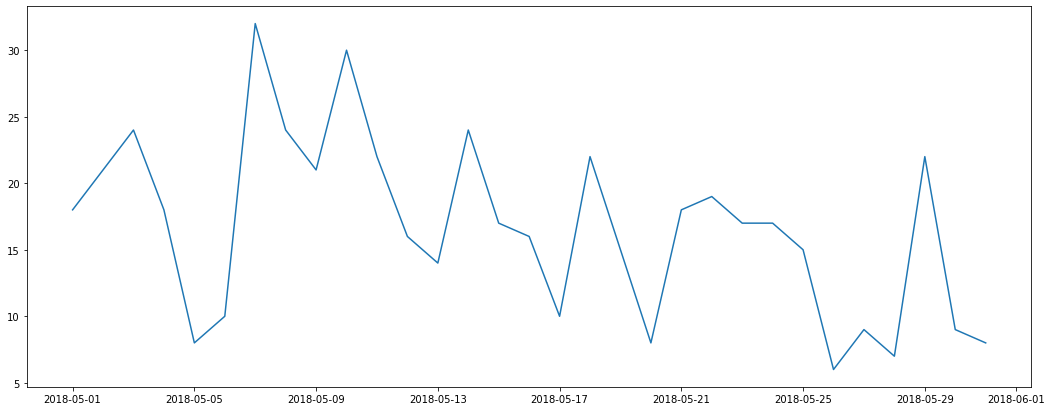

In [ ]:
plt.rcParams["figure.figsize"] = (18,7)
plt.plot(tmp)
plt.show();

### OLD Grafo

In [ ]:
# dizionario: id stazione -> nome stazione
tmp1 = df[['start_station_id', 'start_station_name']]
tmp1.columns = ['id', 'name']
tmp2 = df[['end_station_id', 'end_station_name']]
tmp2.columns = ['id', 'name']
tmp = pd.concat([tmp1, tmp2]).drop_duplicates('id', keep='first')
tmp.set_index('id', inplace=True)
names = tmp.T.to_dict(orient='records')[0]

In [ ]:
# dizionario: id stazione -> coords (media delle coordinate, perché non precise)
tmp1 = df[['start_station_id', 'start_lat', 'start_lng']]
tmp1.columns = ['id', 'lat', 'lng']
tmp2 = df[['end_station_id', 'end_lat', 'end_lng']]
tmp2.columns = ['id', 'lat', 'lng']
tmp = pd.concat([tmp1, tmp2])
tmp = tmp.groupby('id').mean()
coords = tmp.to_dict('index')

In [ ]:
# replace coords in df
for _type in ['start', 'end']:
  for c in ['lat', 'lng']:
    df[_type+'_'+c] = df[_type+'_station_id'].apply(lambda x: coords[x][c])

In [ ]:
import networkx as nx
G = nx.Graph()

for _id in coords:
  G.add_node(_id,pos=(coords[_id]['lat'], coords[_id]['lng']))

pos = nx.get_node_attributes(G,'pos')

In [ ]:
x = df.groupby(["start_station_id", "end_station_id"]).size().reset_index(name="count")

for edge in x.values:
  if edge[2] > 0:
    G.add_edge(edge[0], edge[1], weight=edge[2])

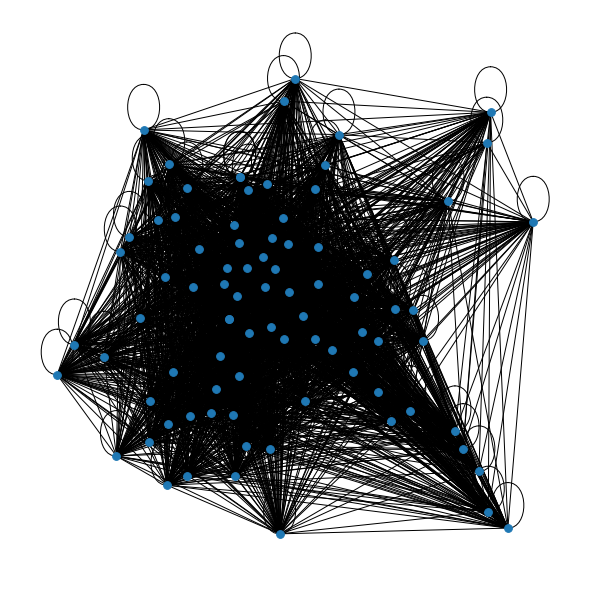

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]

nx.draw(G, pos, font_size=7, with_labels=False, node_size=60)